## Classification With A Bank : Modélisation 


In [258]:
import pickle
import os
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder,OrdinalEncoder

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier


#import metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score


import time
import pickle


from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')

# Préparation des données

In [259]:
path = 'D://etude_data_science//Kaggle_competition//16_Binary_Classification_with_a_Bank//dataset'
path_train = path + "/train.csv"
path_test = path + "/test.csv"

In [260]:
train = pd.read_csv(path_train)
test =  pd.read_csv(path_test)
df = train.copy()

In [261]:
var_num = df.select_dtypes(exclude="object").drop("id",axis=1).columns.tolist()
var_qual = df.select_dtypes("object").columns.tolist()
target = [df.y.name]

var_cont, var_dis = [], []
for i in var_num:
    if df[i].nunique() <= df.campaign.nunique():
        var_dis.append(i)
    else:
        var_cont.append(i)
var_dis.remove("y")

In [262]:
identifiant = df["id"]

## Preprocessing :

#### Séparation en train et test set 

In [263]:
X,y = df.drop(["id","y"],axis=1), df["y"]
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, stratify = y)

#### Standardisation 

In [264]:
std = StandardScaler()
#Fit uniquement sur le train
std.fit(X_train[var_cont])

# Transform train et test avec les mêmes paramètres
X_train[var_cont] = std.transform(X_train[var_cont])
X_test[var_cont]  = std.transform(X_test[var_cont])
X[var_cont] = std.transform(X[var_cont])  

In [265]:
print("X train :", X_train.shape)
print("X test :", X_test.shape)
print("y train :", y_train.shape)
print("y test :", y_test.shape)
print()
print("X :", X.shape)
print("y :", y.shape)

X train : (562500, 16)
X test : (187500, 16)
y train : (562500,)
y test : (187500,)

X : (750000, 16)
y : (750000,)


#### Encodage

In [266]:
# Initialisation de l'encoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit sur le train
encoder.fit(X_train[var_qual])

# Transformation train et test
X_train[var_qual] = encoder.transform(X_train[var_qual])
X_test[var_qual] = encoder.transform(X_test[var_qual])
X[var_qual] = encoder.transform(X[var_qual]) 

# Modélisation :

- Nous allons modéliser ici sans le SMOTE étant donné la quantité de données le code serait trop long
- A la place, nous allons adapté les modèles afin de prendre en compte le cas déséquilibré et de pondéré la classe minoritaire
- Nous somme dans le cadre d'un problème **déséquilibré** avec une proportion 90/10
- Mesurer l'**accuracy** ici n'est pas pertinent, car sa valeur sera élevée. Ce qui nous interèsse ici, c'est de capter la classe minoritaire, lorsqu'un y = 1. Nous pouvons utiliser d'autres metrics sur la cross validation comme : 
    - **recall** pour la détection de la classe minoritaire 
    - **precision** pour éviter les faux positifs coûteux
    - **f1** pour un équilibre précision et rappel
    
Nous allons utiliser le **recall** dans notre cross validation

In [267]:
def evaluer_modele(models, X_train, y_train, X_val, y_val, scoring_crossval):
    """
    Évalue une liste de modèles de classification avec cross-validation, 
    entraînement et prédictions sur un jeu de validation.

    Paramètres
    ----------
    models : list ou sklearn estimator
        Liste de modèles sklearn (ou un seul modèle) à évaluer. 
        Chaque modèle peut être un simple estimateur (ex: LogisticRegression)
        ou un Pipeline (ex: avec preprocessing + modèle).
    
    X_train : pd.DataFrame ou np.ndarray
        Données d'entraînement (features).
    
    y_train : pd.Series ou np.ndarray
        Labels (cible) associés à X_train.
    
    X_val : pd.DataFrame ou np.ndarray
        Données de validation (features) utilisées pour tester les modèles après entraînement.
    
    y_val : pd.Series ou np.ndarray
        Labels (cible) associés à X_val.
    
    scoring_crossval : str
        Métrique de scoring pour la validation croisée, compatible avec `cross_val_score`.
        Exemples : "accuracy", "f1", "roc_auc", "precision", "recall", etc.

    Retourne
    --------
    trained_models : dict
        Dictionnaire contenant chaque modèle entraîné (clé = nom du modèle).
    
    predictions : dict
        Dictionnaire contenant les prédictions (`y_pred`) sur le jeu de validation 
        pour chaque modèle (clé = nom du modèle).
    
    metrics_df : pd.DataFrame
        DataFrame contenant les métriques calculées pour chaque modèle :
        - Accuracy
        - Precision
        - Recall
        - F1-score
        - ROC AUC (si disponible)
        - Exe_time (temps d’entraînement en minutes)
    
    Notes
    -----
    - La fonction affiche pour chaque modèle un graphique représentant les scores 
      de cross-validation sur les différents folds.
    - Si le modèle ne supporte pas `predict_proba`, la colonne "ROC AUC" contiendra `NaN`.
    """
    
    if not isinstance(models, list):
        models = [models]
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'ROC AUC': [], 'Exe_time': []}
    predictions = {}
    trained_models = {}

    for model in models:
        
        model_name = model.__class__.__name__

        # Cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_crossval)

        # Entraînement
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = round((time.time() - start_time) / 60, 2)

        # Prédictions sur la validation
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Stockage des métriques
        metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['Precision'].append(precision_score(y_val, y_pred))
        metrics['Recall'].append(recall_score(y_val, y_pred))
        metrics['F1-score'].append(f1_score(y_val, y_pred))
        metrics['ROC AUC'].append(roc_auc_score(y_val, y_proba) if y_proba is not None else np.nan)
        metrics['Exe_time'].append(training_time)

        predictions[model_name] = y_pred
        trained_models[model_name] = model

        # Graphique CV
        plt.figure(figsize=(8, 3))
        sns.lineplot(x=[i+1 for i in range(len(scores))], y=scores)
        plt.xlabel('n')
        plt.ylabel(scoring_crossval)
        plt.title(f"{model_name}")
        plt.show()

        print(f"{model_name} → average CV score : {round(scores.mean(), 2)}")
        print("-" * 30)

    metrics_df = pd.DataFrame(metrics, index=[
        model.steps[-1][1].__class__.__name__ if hasattr(model, "steps") else model.__class__.__name__
        for model in models
    ])
    return trained_models, predictions, metrics_df

In [268]:
# Calcul du scale_pos_weight pour XGB car nous somme dans un cas de fort déséquilibre 
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

models = [
    # Baseline 
    DummyClassifier(strategy="most_frequent"),
    
    # Logistic Regression : on active class_weight
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    
    # XGBoost : on utilise scale_pos_weight pour gérer le déséquilibre
    XGBClassifier(scale_pos_weight=scale_pos_weight,
                  eval_metric="logloss", 
                  use_label_encoder=False, 
                  random_state=42),
    
    # RandomForest : on active class_weight
    RandomForestClassifier(class_weight="balanced", random_state=42),
    
    # AdaBoost : pas de class_weight direct
    AdaBoostClassifier(random_state=42)
]


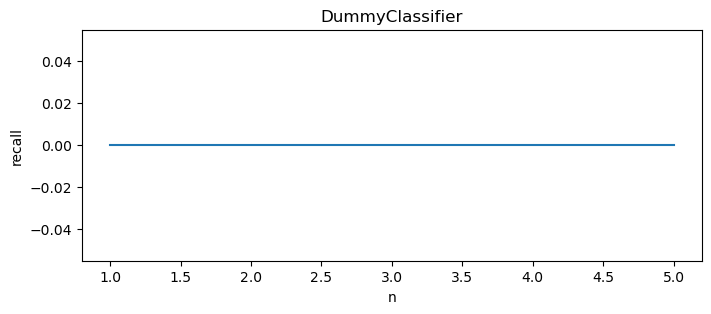

DummyClassifier → average CV score : 0.0
------------------------------


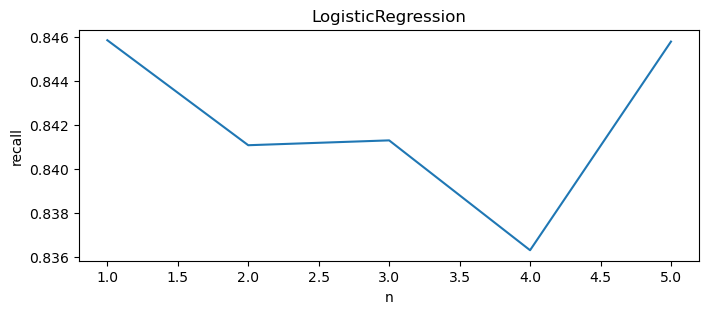

LogisticRegression → average CV score : 0.84
------------------------------


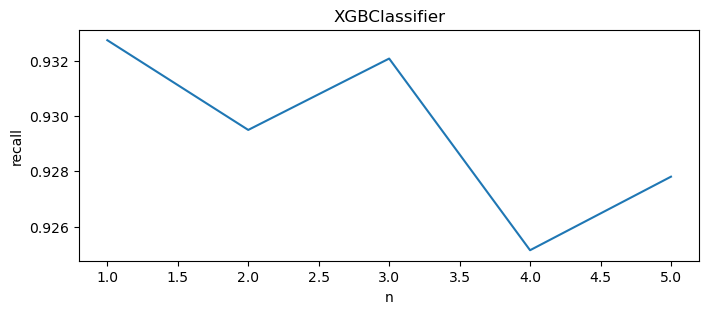

XGBClassifier → average CV score : 0.93
------------------------------


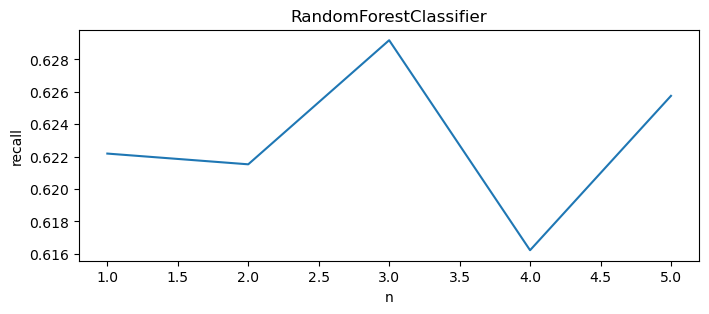

RandomForestClassifier → average CV score : 0.62
------------------------------


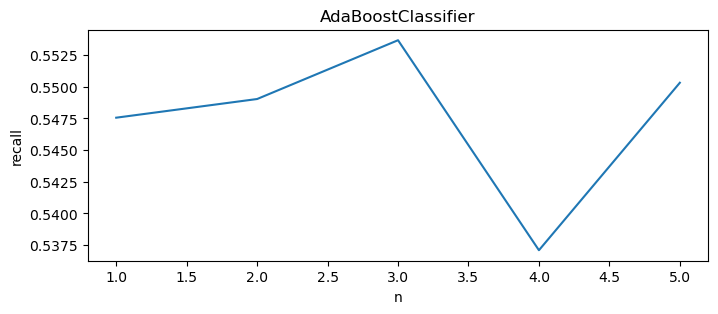

AdaBoostClassifier → average CV score : 0.55
------------------------------


In [269]:
#Entrainement des modèles :
trained_models, predictions, metrics_df = evaluer_modele(models, X_train, y_train, X_test, y_test,"recall")

In [270]:
def vizualisation_metric(dataframe,nrow,ncol,size=(12,10)):
    """Visualisation des différentes metrics de classification"""
    plt.figure(figsize=size)
    for i,col in enumerate(dataframe,1):
        plt.subplot(nrow,ncol,i)
        plt.title(f"{col}")
        ax = sns.barplot(x = dataframe.index, y = col , data = dataframe)
        lab = ax.get_xticklabels()
        ax.set_xticklabels(labels =lab,rotation=45)
        ax.set_ylabel(None)
        plt.tight_layout()
    plt.show()

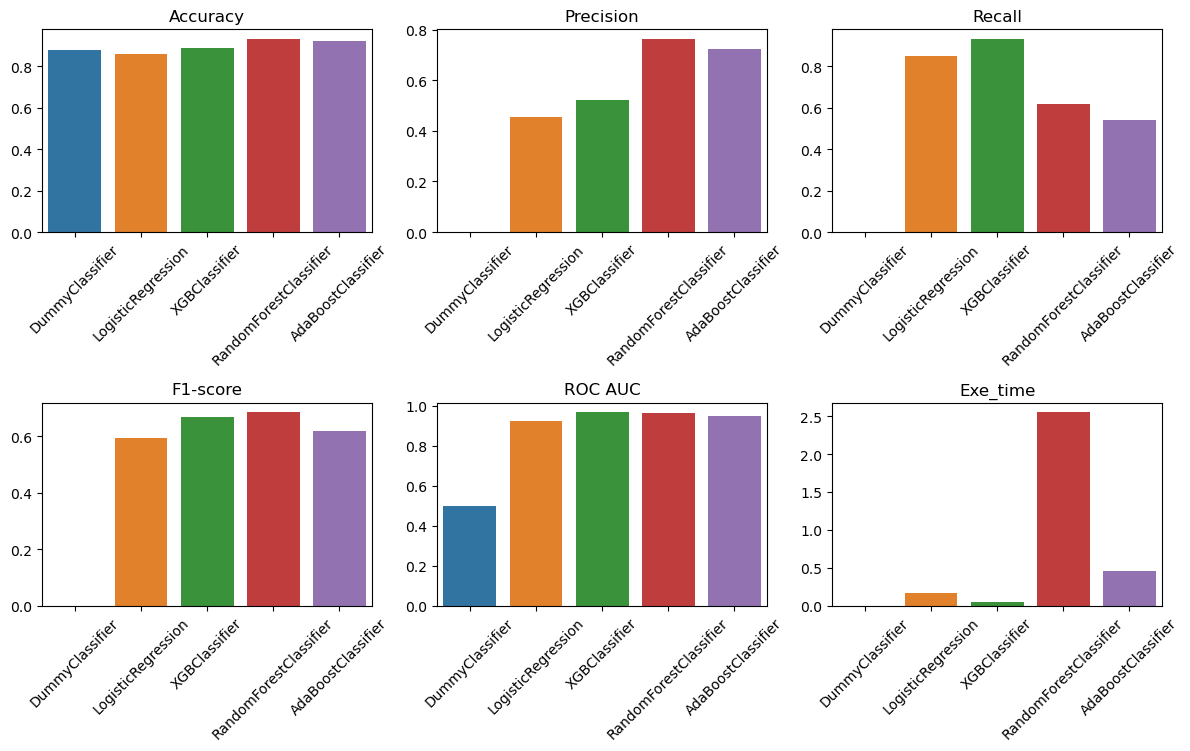

In [271]:
vizualisation_metric(metrics_df, 3,3)

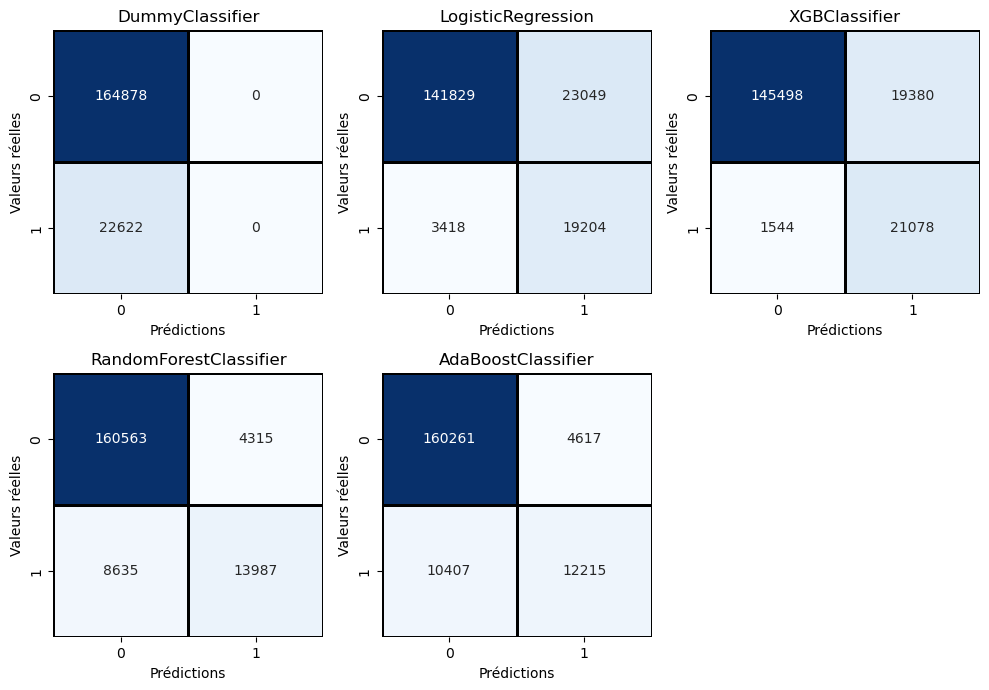

In [272]:
def matrice(pred, nrow, ncol,size): 
    plt.figure(figsize=size)  
    for i, col in enumerate(pred, 1):
        cf = metrics.confusion_matrix(y_true=y_test, y_pred=pred[col])
        ax = plt.subplot(nrow, ncol, i)
        sns.heatmap(cf, annot=True, ax=ax,linewidths=0.8, linecolor="black",fmt=".0f", cbar=False, cmap="Blues")
        ax.set_xlabel('Prédictions')
        ax.set_ylabel('Valeurs réelles')
        ax.set_title(f"{col}")
    plt.tight_layout()  # Pour éviter les chevauchements
    plt.show()
matrice(predictions,3,3,size=(10,10))

In [273]:
def ROC(model_list, X_test, y_test, nrow, ncol):
    """Fonction pour obtenir la courbe ROC pour plusieurs modèles de classification binaire"""
    plt.figure(figsize=(15, 10))

    # Boucle sur chaque modèle et on trace la courbe ROC dans un sous-graphique
    for i, model in enumerate(model_list):
        plt.subplot(nrow, ncol, i + 1)  # i+1 parce que subplot commence à 1

        # Prédiction des probabilités pour le modèle courant
        predicted_probabilities = model_list[model].predict(X_test)

        # Calcul de la courbe ROC et de l'AUC
        fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Tracé de la courbe ROC
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        
        # Ligne en pointillés représentant la performance aléatoire
        plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
        
        # Ajout des légendes et des titres
        plt.legend(loc="lower right")
        plt.xlabel('Taux de faux positifs (FPR)')
        plt.ylabel('Taux de vrais positifs (TPR)')
        plt.title(f'Courbe ROC - {model}')
        plt.grid()

    plt.tight_layout()  
    plt.show()       

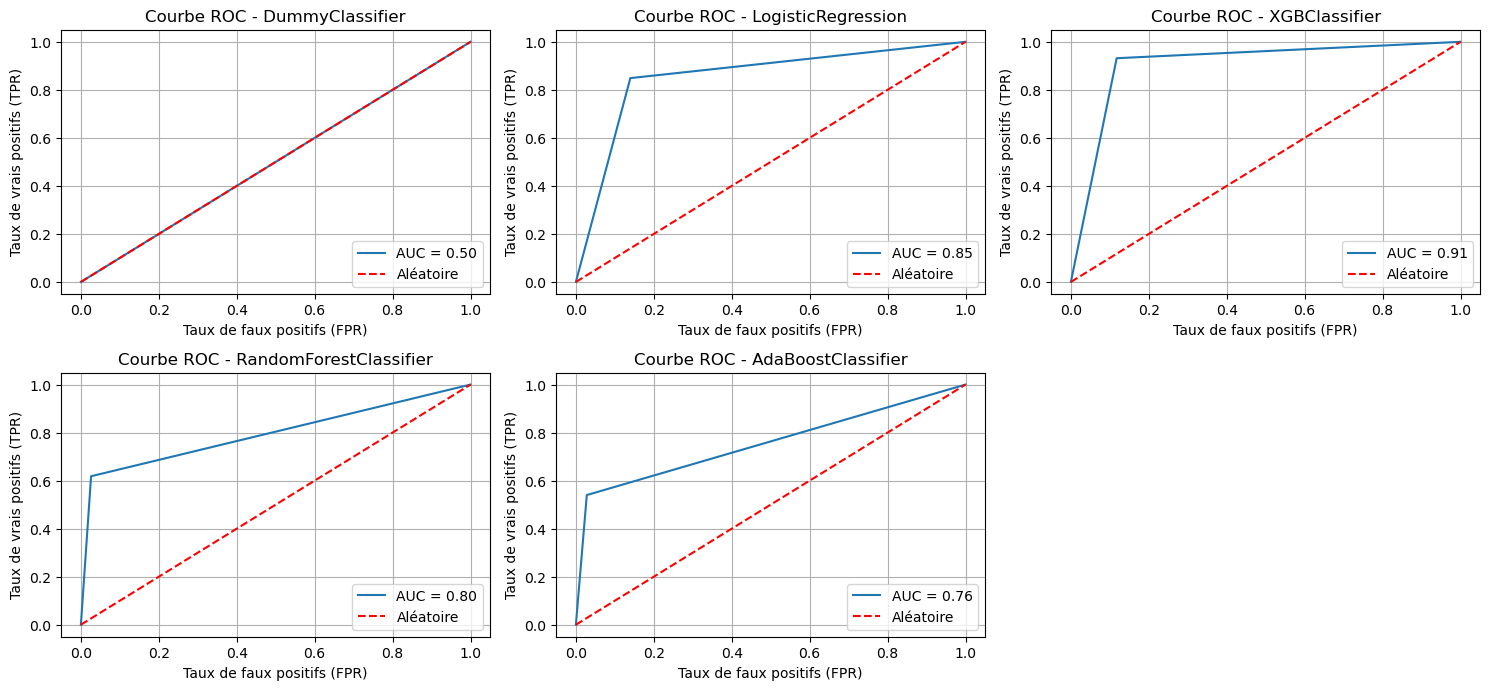

In [274]:
ROC(trained_models, X_test, y_test, 3,3)

### Sélection du/des meilleurs modèles et réentrainement sur l'ensemble du jeu de données :

In [302]:
best_model = trained_models['AdaBoostClassifier']
best_model.fit(X,y)

AdaBoostClassifier(random_state=42)

In [303]:
def save_model(best_model):
    model_name = best_model.__class__.__name__
    
    model_filename = os.path.join(f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(best_model, model_file)
    print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')


In [304]:
save_model(best_model)

AdaBoostClassifier enregistré sous AdaBoostClassifier.pkl


# Nouvelles prédiction sur le test : 

#### Preprocessing test : 

In [ ]:
test[var_cont]  = std.transform(test[var_cont])
test[var_qual] = encoder.transform(test[var_qual])


#### Prediction sur des données nouvelles (test)

In [285]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    numeric_prediction = model.predict(X)
    
    #Conversion des prédiction en données d'origine (textuelles et non numérique)
    # class_predicted = encoder_label.inverse_transform(numeric_prediction)   
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(numeric_prediction, columns = ["y"], index = id_data)
#     prediction_df = pd.DataFrame(class_predicted, columns = ["class"], index = id_data)
    return prediction_df


In [305]:
submission_pred = new_prediction(best_model,test)
#Récupération dans un fichier .csv pour soumission à kaggle
submission_pred.to_csv("prediction_Ada.csv")

## 2. Modélisation avec SMOTE